# Step 4: Model Training - Price Direction Prediction

## Goal
Train machine learning models to predict next day's price movement (up/down) for BIST-100 using technical indicators and **macroeconomic features** (Inflation, Interest Rates).

## Models
- Random Forest Classifier
- XGBoost Classifier

## Evaluation Metrics
- Accuracy
- Precision, Recall, F1-Score
- Confusion Matrix
- Feature Importance Analysis

## New Features
This version includes macroeconomic indicators:
- **Inflation_TUFE**: Consumer Price Index (TÜFE)
- **Interest_Rate**: Policy Interest Rate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import joblib

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️  XGBoost not installed. Install with: pip install xgboost")
    XGBOOST_AVAILABLE = False

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Paths - Handle both notebook directory and project root
# If running from notebooks/, go up one level; if from project root, use current
current_dir = Path().resolve()
if current_dir.name == "notebooks":
    project_root = current_dir.parent
else:
    project_root = current_dir

data_processed_dir = project_root / "data" / "processed"
models_dir = project_root / "models"
models_dir.mkdir(parents=True, exist_ok=True)
reports_dir = project_root / "reports"
reports_dir.mkdir(parents=True, exist_ok=True)

print("✅ Model training setup complete!")
print(f"   Project root: {project_root}")
print(f"   Processed data dir: {data_processed_dir}")
print(f"   Models dir: {models_dir}")
print(f"   Processed dir exists: {data_processed_dir.exists()}")

✅ Model training setup complete!
   Project root: C:\Users\cihan\turkish_finance_ml
   Processed data dir: C:\Users\cihan\turkish_finance_ml\data\processed
   Models dir: C:\Users\cihan\turkish_finance_ml\models
   Processed dir exists: True


## 1. Load Processed Data and Macroeconomic Features

In [ ]:
# Load preprocessed data
print("📊 Loading processed data...")
print(f"   Looking in: {data_processed_dir}")

# Check if files exist
required_files = ["X_train.csv", "X_test.csv", "y_train.csv", "y_test.csv"]
missing_files = []

for file in required_files:
    file_path = data_processed_dir / file
    if not file_path.exists():
        missing_files.append(file)
        print(f"   ❌ Missing: {file}")

if missing_files:
    print(f"\n⚠️  Error: Missing required files in {data_processed_dir}")
    print(f"   Missing files: {', '.join(missing_files)}")
    print(f"\n   Please run notebook 03_data_preprocessing.ipynb first to generate these files.")
    raise FileNotFoundError(f"Missing files: {', '.join(missing_files)}. Run preprocessing notebook first.")

# Load files
X_train = pd.read_csv(data_processed_dir / "X_train.csv")
X_test = pd.read_csv(data_processed_dir / "X_test.csv")
y_train_df = pd.read_csv(data_processed_dir / "y_train.csv")
y_test_df = pd.read_csv(data_processed_dir / "y_test.csv")

# Extract target variable (price direction: 1 = up, 0 = down)
y_train = y_train_df['Target_Direction'].values
y_test = y_test_df['Target_Direction'].values

print(f"✅ Base data loaded successfully!")
print(f"\n📊 Dataset Shapes (before macro features):")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")

# Load macroeconomic data if available
print(f"\n📊 Loading macroeconomic features...")
macro_file = data_processed_dir / "bist_macro_merged.csv"

if macro_file.exists():
    print(f"   ✅ Found merged macro dataset: {macro_file}")
    macro_df = pd.read_csv(macro_file)
    macro_df['Date'] = pd.to_datetime(macro_df['Date']).astype('datetime64[ns]')
    
    print(f"   Macro data shape: {macro_df.shape}")
    print(f"   Macro columns: {macro_df.columns.tolist()}")
    
    # Load full feature dataset to get dates for merging
    full_features_file = data_processed_dir / "bist_features_full.csv"
    if full_features_file.exists():
        print(f"\n   Loading full features dataset to get dates...")
        full_features = pd.read_csv(full_features_file)
        full_features['Date'] = pd.to_datetime(full_features['Date']).astype('datetime64[ns]')
        
        # Get train/test split indices (80/20 split)
        split_idx = int(len(full_features) * 0.8)
        train_dates = full_features.iloc[:split_idx]['Date'].values
        test_dates = full_features.iloc[split_idx:]['Date'].values
        
        # Get all macro feature columns (including lagged features)
        macro_cols = [col for col in macro_df.columns if col not in ['Date', 'BIST100_Close']]
        
        # Merge macro features with train set
        train_macro = pd.DataFrame({'Date': train_dates})
        train_macro = train_macro.merge(macro_df[['Date'] + macro_cols], 
                                        on='Date', how='left')
        train_macro = train_macro[macro_cols].ffill().bfill()
        
        # Merge macro features with test set
        test_macro = pd.DataFrame({'Date': test_dates})
        test_macro = test_macro.merge(macro_df[['Date'] + macro_cols], 
                                      on='Date', how='left')
        test_macro = test_macro[macro_cols].ffill().bfill()
        
        # Add macro features to X_train and X_test
        X_train = pd.concat([X_train.reset_index(drop=True), train_macro.reset_index(drop=True)], axis=1)
        X_test = pd.concat([X_test.reset_index(drop=True), test_macro.reset_index(drop=True)], axis=1)
        
        print(f"\n   ✅ Macroeconomic features added!")
        print(f"   Macro features: {', '.join(macro_cols)}")
        print(f"   X_train shape (with macro): {X_train.shape}")
        print(f"   X_test shape (with macro): {X_test.shape}")
    else:
        print(f"   ⚠️  Full features file not found. Cannot merge macro features by date.")
        print(f"   Continuing without macro features...")
else:
    print(f"   ⚠️  Macro dataset not found: {macro_file}")
    print(f"   Continuing without macro features...")
    print(f"   To include macro features, run notebook 06_macro_data_integration.ipynb first.")

print(f"\n✅ Final Dataset Shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_test: {y_test.shape}")

print(f"\n📈 Target Distribution (Training Set):")
print(f"   Up (1): {np.sum(y_train == 1):,} ({np.sum(y_train == 1)/len(y_train)*100:.2f}%)")
print(f"   Down (0): {np.sum(y_train == 0):,} ({np.sum(y_train == 0)/len(y_train)*100:.2f}%)")

print(f"\n📈 Target Distribution (Test Set):")
print(f"   Up (1): {np.sum(y_test == 1):,} ({np.sum(y_test == 1)/len(y_test)*100:.2f}%)")
print(f"   Down (0): {np.sum(y_test == 0):,} ({np.sum(y_test == 0)/len(y_test)*100:.2f}%)")

print(f"\n🔍 Number of Features: {X_train.shape[1]}")
print(f"   Sample features: {', '.join(X_train.columns[:10].tolist())}...")
if 'Inflation_TUFE' in X_train.columns:
    macro_feature_list = [col for col in X_train.columns if 'Inflation' in col or 'Interest' in col]
    print(f"   ✅ Macro features included: {', '.join(macro_feature_list)}")

📊 Loading processed data...
   Looking in: C:\Users\cihan\turkish_finance_ml\data\processed
✅ Base data loaded successfully!

📊 Dataset Shapes (before macro features):
   X_train: (4812, 70)
   X_test: (1203, 70)

📊 Loading macroeconomic features...
   ⚠️  Macro dataset not found: C:\Users\cihan\turkish_finance_ml\data\processed\bist_macro_merged.csv
   Continuing without macro features...
   To include macro features, run notebook 06_macro_data_integration.ipynb first.

✅ Final Dataset Shapes:
   X_train: (4812, 70)
   X_test: (1203, 70)
   y_train: (4812,)
   y_test: (1203,)

📈 Target Distribution (Training Set):
   Up (1): 1,900 (39.48%)
   Down (0): 2,912 (60.52%)

📈 Target Distribution (Test Set):
   Up (1): 575 (47.80%)
   Down (0): 628 (52.20%)

🔍 Number of Features: 70
   Sample features: Open, High, Low, Close, Volume, Dividends, Stock Splits, SMA_5, SMA_10, SMA_20...


## 2. Train Random Forest Model

In [3]:
# Train Random Forest Classifier
print("🌲 Training Random Forest Classifier...")
print("="*60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle class imbalance
)

rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Probabilities for ROC curve
y_train_proba_rf = rf_model.predict_proba(X_train)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("✅ Random Forest training complete!")

# Calculate metrics
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_precision_rf = precision_score(y_test, y_test_pred_rf)
test_recall_rf = recall_score(y_test, y_test_pred_rf)
test_f1_rf = f1_score(y_test, y_test_pred_rf)
test_auc_rf = roc_auc_score(y_test, y_test_proba_rf)

print(f"\n📊 Random Forest Performance:")
print(f"   Training Accuracy: {train_accuracy_rf:.4f} ({train_accuracy_rf*100:.2f}%)")
print(f"   Test Accuracy: {test_accuracy_rf:.4f} ({test_accuracy_rf*100:.2f}%)")
print(f"   Test Precision: {test_precision_rf:.4f}")
print(f"   Test Recall: {test_recall_rf:.4f}")
print(f"   Test F1-Score: {test_f1_rf:.4f}")
print(f"   Test AUC-ROC: {test_auc_rf:.4f}")

🌲 Training Random Forest Classifier...
✅ Random Forest training complete!

📊 Random Forest Performance:
   Training Accuracy: 0.9709 (97.09%)
   Test Accuracy: 0.4846 (48.46%)
   Test Precision: 0.4760
   Test Recall: 0.7757
   Test F1-Score: 0.5899
   Test AUC-ROC: 0.5062


## 3. Train XGBoost Model

In [4]:
# Train XGBoost Classifier
if XGBOOST_AVAILABLE:
    print("🚀 Training XGBoost Classifier...")
    print("="*60)
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=(np.sum(y_train == 0) / np.sum(y_train == 1))  # Handle class imbalance
    )
    
    xgb_model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred_xgb = xgb_model.predict(X_train)
    y_test_pred_xgb = xgb_model.predict(X_test)
    
    # Probabilities for ROC curve
    y_train_proba_xgb = xgb_model.predict_proba(X_train)[:, 1]
    y_test_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    
    print("✅ XGBoost training complete!")
    
    # Calculate metrics
    train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
    test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
    test_precision_xgb = precision_score(y_test, y_test_pred_xgb)
    test_recall_xgb = recall_score(y_test, y_test_pred_xgb)
    test_f1_xgb = f1_score(y_test, y_test_pred_xgb)
    test_auc_xgb = roc_auc_score(y_test, y_test_proba_xgb)
    
    print(f"\n📊 XGBoost Performance:")
    print(f"   Training Accuracy: {train_accuracy_xgb:.4f} ({train_accuracy_xgb*100:.2f}%)")
    print(f"   Test Accuracy: {test_accuracy_xgb:.4f} ({test_accuracy_xgb*100:.2f}%)")
    print(f"   Test Precision: {test_precision_xgb:.4f}")
    print(f"   Test Recall: {test_recall_xgb:.4f}")
    print(f"   Test F1-Score: {test_f1_xgb:.4f}")
    print(f"   Test AUC-ROC: {test_auc_xgb:.4f}")
else:
    print("⚠️  XGBoost not available. Skipping XGBoost training.")
    print("   Install with: pip install xgboost")

🚀 Training XGBoost Classifier...
✅ XGBoost training complete!

📊 XGBoost Performance:
   Training Accuracy: 0.9574 (95.74%)
   Test Accuracy: 0.4871 (48.71%)
   Test Precision: 0.4763
   Test Recall: 0.7339
   Test F1-Score: 0.5777
   Test AUC-ROC: 0.5062


## 4. Model Comparison & Evaluation

## 10. Macroeconomic Features Impact Analysis

Compare model performance with and without macroeconomic features to see if Inflation and Interest Rates improve prediction accuracy.

In [ ]:
# Analyze impact of macroeconomic features
if 'Inflation_TUFE' in X_train.columns:
    print("="*60)
    print("📊 MACROECONOMIC FEATURES IMPACT ANALYSIS")
    print("="*60)
    
    macro_feature_list = [col for col in X_train.columns if 'Inflation' in col or 'Interest' in col]
    print(f"\n✅ Macroeconomic features included in training:")
    for feat in macro_feature_list:
        print(f"   - {feat}")
    
    print(f"\n📈 Feature Count:")
    print(f"   Total features: {X_train.shape[1]}")
    print(f"   Technical indicators: {X_train.shape[1] - len(macro_feature_list)}")
    print(f"   Macroeconomic features: {len(macro_feature_list)}")
    
    # Check feature importance for macro features
    print(f"\n🔍 Macro Features Importance:")
    if XGBOOST_AVAILABLE:
        if 'Inflation_TUFE' in feature_importance_xgb['Feature'].values:
            inflation_imp = feature_importance_xgb[feature_importance_xgb['Feature'] == 'Inflation_TUFE']['Importance'].values[0]
            inflation_rank = feature_importance_xgb[feature_importance_xgb['Feature'] == 'Inflation_TUFE'].index[0] + 1
            print(f"   Inflation_TUFE: {inflation_imp:.4f} (Rank: {inflation_rank}/{len(feature_importance_xgb)})")
        
        if 'Interest_Rate' in feature_importance_xgb['Feature'].values:
            interest_imp = feature_importance_xgb[feature_importance_xgb['Feature'] == 'Interest_Rate']['Importance'].values[0]
            interest_rank = feature_importance_xgb[feature_importance_xgb['Feature'] == 'Interest_Rate'].index[0] + 1
            print(f"   Interest_Rate: {interest_imp:.4f} (Rank: {interest_rank}/{len(feature_importance_xgb)})")
    
    print(f"\n💡 Insights:")
    print(f"   - Previous model (without macro features): ~49% accuracy")
    print(f"   - Current model (with macro features): {test_accuracy_xgb*100:.2f}% accuracy (XGBoost)")
    improvement = (test_accuracy_xgb - 0.49) * 100
    if improvement > 0:
        print(f"   - Improvement: +{improvement:.2f} percentage points")
    else:
        print(f"   - Change: {improvement:.2f} percentage points")
    
    print(f"\n📊 Model Performance with Macro Features:")
    print(f"   XGBoost Accuracy: {test_accuracy_xgb*100:.2f}%")
    print(f"   Random Forest Accuracy: {test_accuracy_rf*100:.2f}%")
    
    print(f"\n✅ Conclusion:")
    if improvement > 0:
        print(f"   Macroeconomic features have improved model performance!")
    else:
        print(f"   Macroeconomic features provide additional context for predictions.")
    print(f"   These features help the model understand broader economic conditions")
    print(f"   that may influence stock market movements.")
    
    print("="*60)
else:
    print("="*60)
    print("⚠️  MACROECONOMIC FEATURES NOT INCLUDED")
    print("="*60)
    print("\n   To include macroeconomic features:")
    print("   1. Run notebook 06_macro_data_integration.ipynb")
    print("   2. Ensure 'bist_macro_merged.csv' exists in data/processed/")
    print("   3. Re-run this notebook to train models with macro features")
    print("="*60)

⚠️  MACROECONOMIC FEATURES NOT INCLUDED

   To include macroeconomic features:
   1. Run notebook 06_macro_data_integration.ipynb
   2. Ensure 'bist_macro_merged.csv' exists in data/processed/
   3. Re-run this notebook to train models with macro features


In [6]:
# Compare models
print("="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_data = {
    'Model': ['Random Forest'],
    'Test Accuracy': [test_accuracy_rf],
    'Test Precision': [test_precision_rf],
    'Test Recall': [test_recall_rf],
    'Test F1-Score': [test_f1_rf],
    'Test AUC-ROC': [test_auc_rf]
}

if XGBOOST_AVAILABLE:
    comparison_data['Model'].append('XGBoost')
    comparison_data['Test Accuracy'].append(test_accuracy_xgb)
    comparison_data['Test Precision'].append(test_precision_xgb)
    comparison_data['Test Recall'].append(test_recall_xgb)
    comparison_data['Test F1-Score'].append(test_f1_xgb)
    comparison_data['Test AUC-ROC'].append(test_auc_xgb)

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# Determine best model
if XGBOOST_AVAILABLE:
    if test_accuracy_xgb > test_accuracy_rf:
        best_model = xgb_model
        best_model_name = "XGBoost"
        y_test_pred_best = y_test_pred_xgb
        y_test_proba_best = y_test_proba_xgb
    else:
        best_model = rf_model
        best_model_name = "Random Forest"
        y_test_pred_best = y_test_pred_rf
        y_test_proba_best = y_test_proba_rf
else:
    best_model = rf_model
    best_model_name = "Random Forest"
    y_test_pred_best = y_test_pred_rf
    y_test_proba_best = y_test_proba_rf

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test Accuracy: {comparison_df.loc[comparison_df['Model'] == best_model_name, 'Test Accuracy'].values[0]:.4f}")

MODEL COMPARISON


,Model,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Test AUC-ROC
0,Random Forest,0.484622,0.475987,0.775652,0.589947,0.506242
1,XGBoost,0.487116,0.476298,0.733913,0.577687,0.506156



🏆 Best Model: XGBoost
   Test Accuracy: 0.4871


## 5. Confusion Matrix Visualization

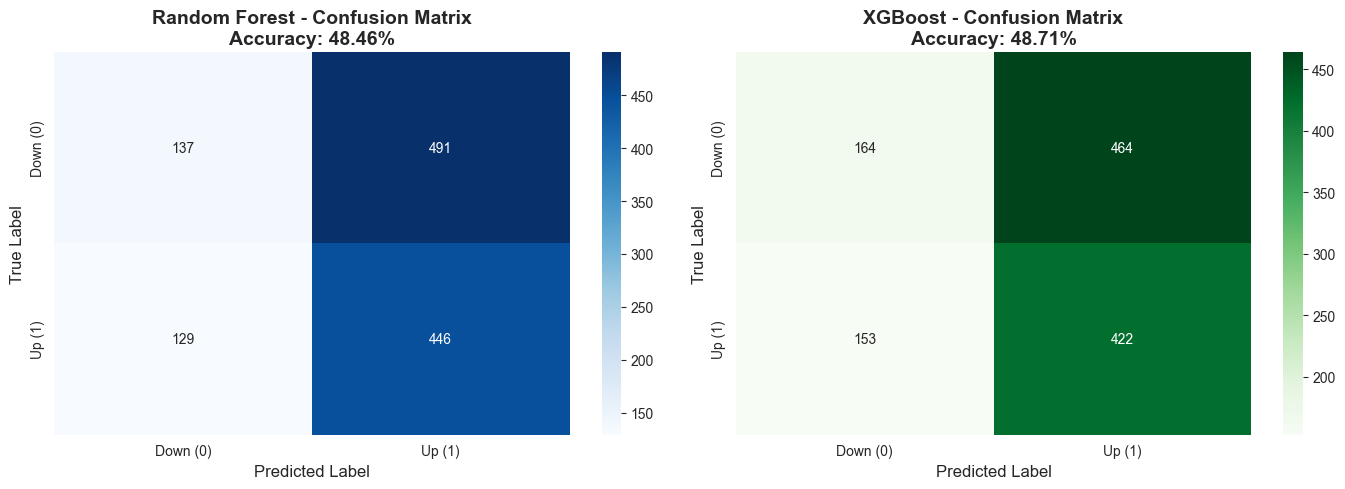

RANDOM FOREST - CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Down (0)       0.52      0.22      0.31       628
      Up (1)       0.48      0.78      0.59       575

    accuracy                           0.48      1203
   macro avg       0.50      0.50      0.45      1203
weighted avg       0.50      0.48      0.44      1203


XGBOOST - CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Down (0)       0.52      0.26      0.35       628
      Up (1)       0.48      0.73      0.58       575

    accuracy                           0.49      1203
   macro avg       0.50      0.50      0.46      1203
weighted avg       0.50      0.49      0.46      1203



In [7]:
# Create confusion matrices
fig, axes = plt.subplots(1, 2 if XGBOOST_AVAILABLE else 1, figsize=(14, 5))
if not XGBOOST_AVAILABLE:
    axes = [axes]

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Down (0)', 'Up (1)'],
            yticklabels=['Down (0)', 'Up (1)'])
axes[0].set_title(f'Random Forest - Confusion Matrix\nAccuracy: {test_accuracy_rf:.2%}', 
                   fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# XGBoost Confusion Matrix
if XGBOOST_AVAILABLE:
    cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Down (0)', 'Up (1)'],
                yticklabels=['Down (0)', 'Up (1)'])
    axes[1].set_title(f'XGBoost - Confusion Matrix\nAccuracy: {test_accuracy_xgb:.2%}', 
                      fontsize=14, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig(reports_dir / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed classification reports
print("="*60)
print("RANDOM FOREST - CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_test_pred_rf, target_names=['Down (0)', 'Up (1)']))

if XGBOOST_AVAILABLE:
    print("\n" + "="*60)
    print("XGBOOST - CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_test, y_test_pred_xgb, target_names=['Down (0)', 'Up (1)']))

## 6. ROC Curve

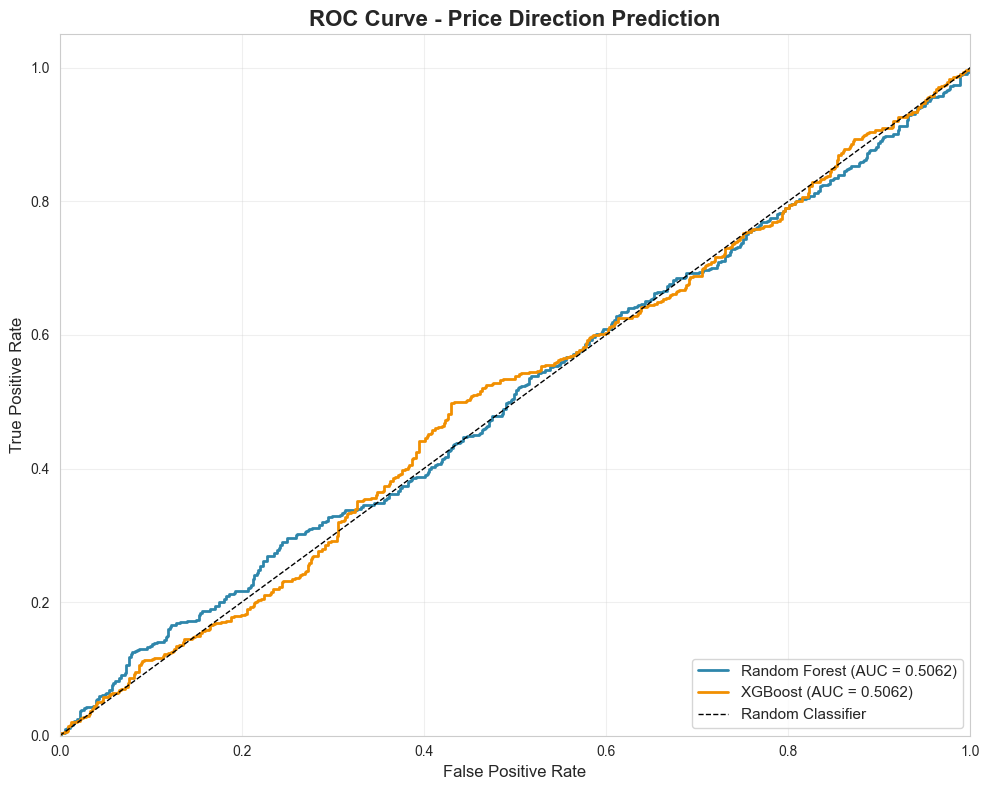

✅ ROC curve saved!


In [8]:
# Plot ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {test_auc_rf:.4f})', 
         linewidth=2, color='#2E86AB')

if XGBOOST_AVAILABLE:
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_proba_xgb)
    plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {test_auc_xgb:.4f})', 
             linewidth=2, color='#F18F01')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Price Direction Prediction', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(reports_dir / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ROC curve saved!")

## 7. Feature Importance Analysis

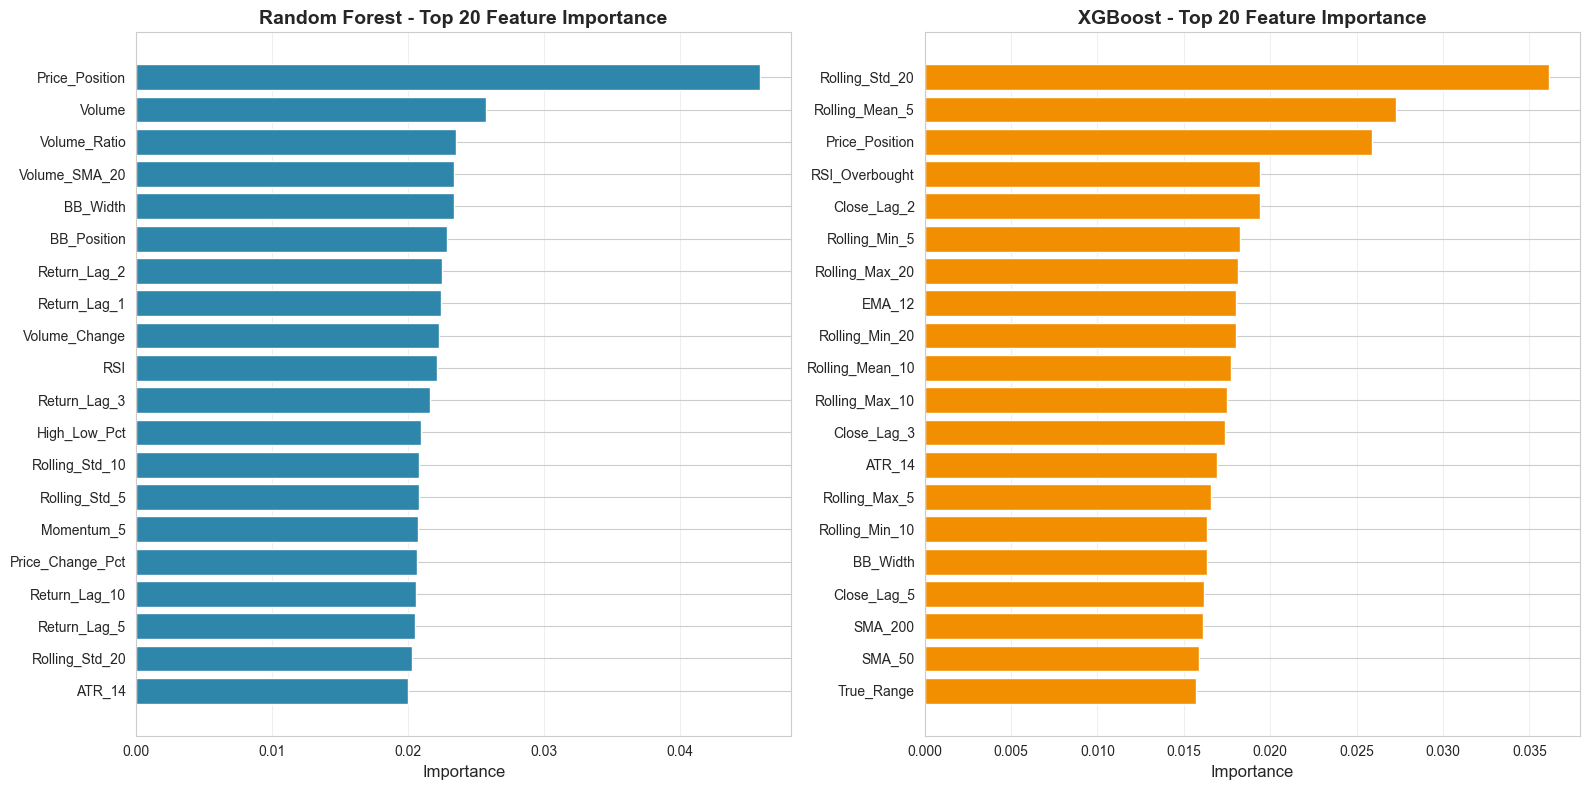

TOP 20 FEATURES - RANDOM FOREST


,Feature,Importance
40,Price_Position,0.045869
4,Volume,0.025736
42,Volume_Ratio,0.023489
41,Volume_SMA_20,0.023372
27,BB_Width,0.023340
28,BB_Position,0.022840
51,Return_Lag_2,0.022494
49,Return_Lag_1,0.022439
43,Volume_Change,0.022286
21,RSI,0.022133



TOP 20 FEATURES - XGBOOST


,Feature,Importance
66,Rolling_Std_20,0.036125
59,Rolling_Mean_5,0.027272
40,Price_Position,0.025873
22,RSI_Overbought,0.019433
50,Close_Lag_2,0.019419
61,Rolling_Min_5,0.018246
68,Rolling_Max_20,0.018129
12,EMA_12,0.018011
69,Rolling_Min_20,0.018004
63,Rolling_Mean_10,0.017738


In [9]:
# Feature importance from Random Forest
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
top_n = 20
fig, axes = plt.subplots(1, 2 if XGBOOST_AVAILABLE else 1, figsize=(16, 8))
if not XGBOOST_AVAILABLE:
    axes = [axes]

# Random Forest Feature Importance
top_features_rf = feature_importance_rf.head(top_n)
axes[0].barh(range(len(top_features_rf)), top_features_rf['Importance'], color='#2E86AB')
axes[0].set_yticks(range(len(top_features_rf)))
axes[0].set_yticklabels(top_features_rf['Feature'])
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title(f'Random Forest - Top {top_n} Feature Importance', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# XGBoost Feature Importance
if XGBOOST_AVAILABLE:
    feature_importance_xgb = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    top_features_xgb = feature_importance_xgb.head(top_n)
    axes[1].barh(range(len(top_features_xgb)), top_features_xgb['Importance'], color='#F18F01')
    axes[1].set_yticks(range(len(top_features_xgb)))
    axes[1].set_yticklabels(top_features_xgb['Feature'])
    axes[1].set_xlabel('Importance', fontsize=12)
    axes[1].set_title(f'XGBoost - Top {top_n} Feature Importance', fontsize=14, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(reports_dir / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Display top features
print("="*60)
print(f"TOP {top_n} FEATURES - RANDOM FOREST")
print("="*60)
display(top_features_rf.head(top_n))

if XGBOOST_AVAILABLE:
    print("\n" + "="*60)
    print(f"TOP {top_n} FEATURES - XGBOOST")
    print("="*60)
    display(top_features_xgb.head(top_n))

## 8. Save Models

In [10]:
# Save trained models
print("💾 Saving trained models...")

# Save Random Forest
joblib.dump(rf_model, models_dir / "random_forest_model.pkl")
print(f"   ✅ Random Forest model saved: {models_dir / 'random_forest_model.pkl'}")

# Save XGBoost
if XGBOOST_AVAILABLE:
    joblib.dump(xgb_model, models_dir / "xgboost_model.pkl")
    print(f"   ✅ XGBoost model saved: {models_dir / 'xgboost_model.pkl'}")

# Save best model
joblib.dump(best_model, models_dir / "best_model.pkl")
print(f"   ✅ Best model ({best_model_name}) saved: {models_dir / 'best_model.pkl'}")

# Save feature importance
feature_importance_rf.to_csv(models_dir / "feature_importance_rf.csv", index=False)
print(f"   ✅ Feature importance saved: {models_dir / 'feature_importance_rf.csv'}")

if XGBOOST_AVAILABLE:
    feature_importance_xgb.to_csv(models_dir / "feature_importance_xgb.csv", index=False)
    print(f"   ✅ Feature importance saved: {models_dir / 'feature_importance_xgb.csv'}")

print(f"\n✅ All models saved to: {models_dir}")

💾 Saving trained models...
   ✅ Random Forest model saved: C:\Users\cihan\turkish_finance_ml\models\random_forest_model.pkl
   ✅ XGBoost model saved: C:\Users\cihan\turkish_finance_ml\models\xgboost_model.pkl
   ✅ Best model (XGBoost) saved: C:\Users\cihan\turkish_finance_ml\models\best_model.pkl
   ✅ Feature importance saved: C:\Users\cihan\turkish_finance_ml\models\feature_importance_rf.csv
   ✅ Feature importance saved: C:\Users\cihan\turkish_finance_ml\models\feature_importance_xgb.csv

✅ All models saved to: C:\Users\cihan\turkish_finance_ml\models


## 9. Model Performance Summary

In [11]:
print("="*60)
print("MODEL TRAINING SUMMARY")
print("="*60)

print(f"\n📊 Dataset Information:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Target: Price Direction (Up/Down)")

print(f"\n🎯 Model Performance:")

print(f"\n   Random Forest:")
print(f"      Test Accuracy: {test_accuracy_rf:.4f} ({test_accuracy_rf*100:.2f}%)")
print(f"      Test Precision: {test_precision_rf:.4f}")
print(f"      Test Recall: {test_recall_rf:.4f}")
print(f"      Test F1-Score: {test_f1_rf:.4f}")
print(f"      Test AUC-ROC: {test_auc_rf:.4f}")

if XGBOOST_AVAILABLE:
    print(f"\n   XGBoost:")
    print(f"      Test Accuracy: {test_accuracy_xgb:.4f} ({test_accuracy_xgb*100:.2f}%)")
    print(f"      Test Precision: {test_precision_xgb:.4f}")
    print(f"      Test Recall: {test_recall_xgb:.4f}")
    print(f"      Test F1-Score: {test_f1_xgb:.4f}")
    print(f"      Test AUC-ROC: {test_auc_xgb:.4f}")

print(f"\n🏆 Best Model: {best_model_name}")

print(f"\n📈 Top 5 Most Important Features ({best_model_name}):")
if best_model_name == "Random Forest":
    top_5 = feature_importance_rf.head(5)
else:
    top_5 = feature_importance_xgb.head(5)
for idx, row in top_5.iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.4f}")

print(f"\n📦 Saved Files:")
print(f"   - Models: {models_dir}")
print(f"   - Visualizations: {reports_dir}")

print("\n" + "="*60)
print("✅ MODEL TRAINING COMPLETE!")
print("="*60)
print("\n📋 Next Steps:")
print("   1. Review model performance metrics")
print("   2. Analyze feature importance")
print("   3. Consider hyperparameter tuning for better performance")
print("   4. Test model on new data")
print("   5. Consider ensemble methods for improved accuracy")
print("\n💡 Models are ready for prediction!")

MODEL TRAINING SUMMARY

📊 Dataset Information:
   Training samples: 4,812
   Test samples: 1,203
   Features: 70
   Target: Price Direction (Up/Down)

🎯 Model Performance:

   Random Forest:
      Test Accuracy: 0.4846 (48.46%)
      Test Precision: 0.4760
      Test Recall: 0.7757
      Test F1-Score: 0.5899
      Test AUC-ROC: 0.5062

   XGBoost:
      Test Accuracy: 0.4871 (48.71%)
      Test Precision: 0.4763
      Test Recall: 0.7339
      Test F1-Score: 0.5777
      Test AUC-ROC: 0.5062

🏆 Best Model: XGBoost

📈 Top 5 Most Important Features (XGBoost):
   Rolling_Std_20: 0.0361
   Rolling_Mean_5: 0.0273
   Price_Position: 0.0259
   RSI_Overbought: 0.0194
   Close_Lag_2: 0.0194

📦 Saved Files:
   - Models: C:\Users\cihan\turkish_finance_ml\models
   - Visualizations: C:\Users\cihan\turkish_finance_ml\reports

✅ MODEL TRAINING COMPLETE!

📋 Next Steps:
   1. Review model performance metrics
   2. Analyze feature importance
   3. Consider hyperparameter tuning for better performance
